# Importo librerias

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Cargado de archivos

In [55]:
X, Y, V = [], [], [] # --> Cada elemento de la lista corresponde a los datos de una longitud de onda

folder = 'Mediciones'
fname = os.listdir(folder + '/')
for file in fname:
    root = folder + '/' + file
    if file[:7] == 'voltaje':
        medXYV = np.genfromtxt(root, delimiter = ',')
        N = len(medXYV)
        Xi, Yi, Vi = np.zeros(N - 1), np.zeros(N - 1), np.zeros(N - 1)
        for i, row in enumerate(medXYV[1:]):
            Xi[i], Yi[i], Vi[i] = row[0], row[1], row[2]
        X.append(Xi), Y.append(Yi), V.append(Vi)

R = [np.sqrt(x**2 + y**2) for x, y in zip(X, Y)]

# Cálculo de $I$ y $V_0$

In [ ]:
G = 10e6
I = [np.sqrt( (x/G)**2 + (y/G)**2 ) for x, y in zip(X, Y)]

# Obtengo el V / I = 0
def V0min(i, v, epsilon = .15e-17, p = -1):
    ic = i[(i >= 0) & (i <= epsilon)]
    vc = v[(i >= 0) & (i <= epsilon)]
    
    ic0, vc0, ind_vc0 = ic[p], vc[p], list(vc).index(vc[p])
    err_vc0 = np.mean([vc0 - v[ind_vc0 - 1], v[ind_vc0 + 1] - vc0])
    
    return ic0, vc0, err_vc0
    
I0, V0, err_V0 = [ V0min(Ik, Vk)[0] for Ik, Vk in zip(I, V)], [ V0min(Ik, Vk)[1] for Ik, Vk in zip(I, V)], [ V0min(Ik, Vk)[2] for Ik, Vk in zip(I, V)]


# Gráficos de las mediciones

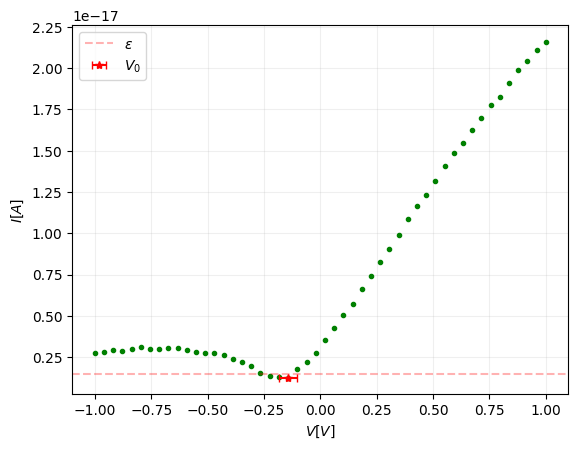

In [77]:
for k in range(len(I)):
    plt.figure()
    
    plt.plot(V[k], I[k], '.', color = 'green')
    plt.errorbar(V0[k], I0[k], fmt = '*', xerr = err_V0[k], capsize = 3, 
                 linestyle = 'None', color = 'red', label = r'$V_0$') #-->Puntos de corriente nula
    
    plt.axhline(.15e-17, color = 'red', linestyle = '--', 
                alpha = 0.3, label = r'$\epsilon$') #--> Referencia tomada
    
    plt.xlabel(r'$V \left[V\right]$')
    plt.ylabel(r'$I \left[A\right]$')
    
    plt.grid(alpha = 0.2)
    plt.legend(loc = 'upper left')
    plt.show()

# Gráficos de ajuste

Función de ajuste:
$eV_0 = h \nu - \hat{\phi}$

In [ ]:
# Deberíamos conocer bien cual es la longitud de onda del led